# Qwen2.5
Qwen/Qwen2.5-VL-7B-Instruct   
결과물이 json형태로 제대로 안나오면 전처리 계속해야함..

In [1]:
# 1.세팅
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
from PIL import Image
import torch
import json

# 테스트 데이터 로드
image_path = "./data/easy_task_test05_v1.PNG"
image = Image.open(image_path).convert("RGB")

/home/dibaeck/miniconda3/envs/proj_311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
torch_dtype = torch.float16
print("------------------ Setup Check ------------------")
print("Using device:", device)
print("Using torch_dtype:", torch_dtype)

# 2.모델 로드
model_id = "Qwen/Qwen2.5-VL-7B-Instruct"

print(f"Loading {model_id} Large model...")
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch_dtype             # torch.float32
).eval().to(device)

processor = AutoProcessor.from_pretrained(model_id)

------------------ Setup Check ------------------
Using device: cuda:0
Using torch_dtype: torch.float16
Loading Qwen/Qwen2.5-VL-7B-Instruct Large model...


Loading checkpoint shards: 100%|██████████| 5/5 [00:01<00:00,  3.19it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
prompt = """
You are an object detection assistant. 
Detect all objects in the input image and classify them according to these classes:
text, rect_solid, rect_dashed, line_solid, line_dashed.
For each object, provide:
- class name
- bounding box coordinates in [x_min, y_min, x_max, y_max] format
- for text objects, include the text content in a "text" field

Output as JSON list.
"""

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_path,  
            },
            {
                "type": "text",
                "text": prompt
            },
        ],
    }
]


# 프롬프트 처리
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

# 이미지 처리
image_inputs, video_inputs = process_vision_info(messages)

inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt"
)
inputs = inputs.to(device)

# 모델 추론
generated_ids = model.generate(**inputs, max_new_tokens=512)

# 입력 토큰 길이 제외
generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]

# 텍스트 디코딩
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text[0])  # JSON 형태 문자열


```json
[
    {"bbox_2d": [108, 134, 176, 150], "class_name": "text", "text": "H1B1-750-AI-101"},
    {"bbox_2d": [108, 150, 198, 166], "class_name": "text", "text": "NO.1 SINTER PLC"},
    {"bbox_2d": [108, 166, 198, 182], "class_name": "text", "text": "RI/O PANEL"},
    {"bbox_2d": [108, 182, 198, 198], "class_name": "text", "text": "(스물기 GROUP)"},
    {"bbox_2d": [108, 282, 176, 298], "class_name": "text", "text": "S-PTC103A-A1"},
    {"bbox_2d": [108, 382, 176, 398], "class_name": "text", "text": "S-PTC103B-A1"},
    {"bbox_2d": [108, 496, 176, 512], "class_name": "text", "text": "S-PTC103D-A1"},
    {"bbox_2d": [108, 656, 176, 672], "class_name": "text", "text": "S-TTC103B-A1"},
    {"bbox_2d": [108, 198, 176, 214], "class_name": "text", "text": "0.6/1KV F-CWSB 2C 1.5SQ"},
    {"bbox_2d": [108, 300, 176, 316], "class_name": "text", "text": "0.6/1KV F-CWSB 2C 1.5SQ"},
    {"bbox_2d": [108, 398


### ISSUE.
> 결과물 생성하다가 중간에 끊기는 거 같음.

In [4]:
test_text = '```json\n[\n    {"bbox_2d": [108, 134, 176, 150], "class_name": "text", "text": "H1B1-750-AI-101"},\n    {"bbox_2d": [108, 150, 190, 166], "class_name": "text", "text": "NO.1 SINTER PLC"},\n    {"bbox_2d": [108, 166, 190, 182], "class_name": "text", "text": "RI/O PANEL"},\n    {"bbox_2d": [108, 182, 190, 198], "class_name": "text", "text": "(스물기 GROUP)"},\n    {"bbox_2d": [108, 284, 176, 300], "class_name": "text", "text": "S-PTC103A-A1"},\n    {"bbox_2d": [108, 300, 190, 316], "class_name": "text", "text": "0.6/1KV F-CWSB 2C 1.5SQ"},\n    {"bbox_2d": [108, 396, 176, 412], "class_name": "text", "text": "S-PTC103C-A1"},\n    {"bbox_2d": [108, 412, 190, 428], "class_name": "text", "text": "0.6/1KV F-CWSB 2C 1.5SQ"},\n    {"bbox_2d": [108, 508, 176, 524], "class_name": "text", "text": "S-PTC103D-A1"},\n    {"bbox_2d": [108, 524, 190, 540], "class_name": "text", "text": "0.6/1KV F-CWSB 2C 1.5SQ"}]'

In [5]:
import json
import re

def text_prosessing(output_text):
    clean_text = output_text.strip().replace("```json", "").replace("```", "")
    clean_text = clean_text.strip().replace("[\n", "[").replace(",\n\\\]'", "")
    clean_text = clean_text.strip().replace("\n    ", "")
    clean_text = re.sub(r",\s*\]$", "]", clean_text)
    clean_text = clean_text.replace("\\", "")
    clean_text = clean_text.strip()

    output_json = json.loads(clean_text)

    return output_json

#output_json = text_prosessing(output_text[0])
output_json = text_prosessing(test_text)

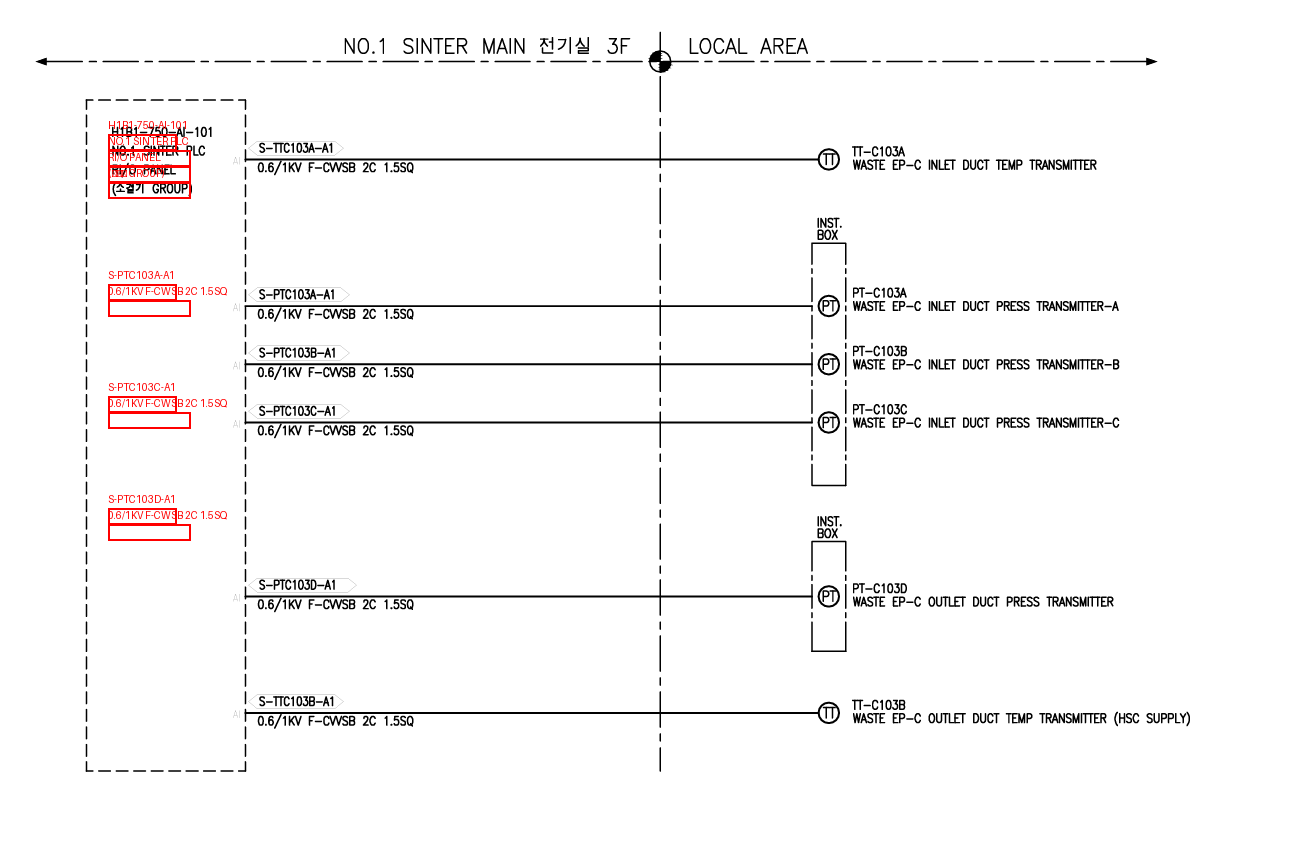

1 : H1B1-750-AI-101
2 : NO.1 SINTER PLC
3 : RI/O PANEL
4 : (스물기 GROUP)
5 : S-PTC103A-A1
6 : 0.6/1KV F-CWSB 2C 1.5SQ
7 : S-PTC103C-A1
8 : 0.6/1KV F-CWSB 2C 1.5SQ
9 : S-PTC103D-A1
10 : 0.6/1KV F-CWSB 2C 1.5SQ


In [7]:
from PIL import Image, ImageDraw, ImageFont
import json
import ast

# 1. 이미지 불러오기
image = Image.open(image_path).convert("RGB")

# 2. 모델 출력 문자열


# 3. 색상 매핑 (클래스별)
color_map = {
    "text": "red",
    "rect_solid": "green",
    "rect_dashed": "blue",
    "line_solid": "yellow",
    "line_dashed": "orange",
}

# 4. 이미지에 bbox 그리기
draw = ImageDraw.Draw(image)
try:
    font = ImageFont.truetype("arial.ttf", 15)
except:
    font = ImageFont.load_default()
color_map = {
    "text": "red",
    "box": "green",
    # 필요하면 클래스별 추가
}
for obj in output_json:
    x_min, y_min, x_max, y_max = obj["bbox_2d"]
    label = obj.get("label") or obj.get("class_name")
    color = color_map.get(label, "white")

    # bbox
    draw.rectangle([x_min, y_min, x_max, y_max], outline=color, width=2)
    
    # 텍스트
    text_label = obj.get("text", label)  # text가 있으면 표시
    draw.text((x_min, y_min - 15), text_label, fill=color, font=font)

# 시각화
image.show()


for idx, obj in enumerate(output_json):
    if obj['class_name'] != 'text': 
        continue
    print(f'{idx+1} : {obj["text"]}')